# Projet numérique - Nathan Bertho, Hadrien Goux

On cherche à calculer puis représenter les lignes de niveaux d'une fonction à deux variables réelles continuement différentiable. Pour ce faire, il nous est proposé de diviser le domaine de la fonction en cellule carrées sur lesquelles on va étudier des fragments de lignes de niveau. On pourra ainsi appliquer des programmes élémentaires à l'échelle d'une cellule, puis assembler les différents fragments en lignes de niveau.

# Partie I : find_seed

On a supposé f continuement différientable. Une condition suffisante sur f(0,0), f(O,1) et le réel c pour avoir un t dans [0,1] tel que f(0,t)=c est d'avoir $g: y \to \ f(0,y)$ monotone et c inclus dans [g(0),g(1)] ou [g(1),g(0)] selon le sens de cette monotonie. Autrement dit, il suffit que (g(1)-c)x(g(0)-c) soit une quantité négative, ce qui correspond à observer un changement de signe de $h: y \to \ g(y)-c$ entre 0 et 1.

La première fonction élémentaire consiste en la détection d'un tel t sur l'arête gauche d'une cellule élémentaire $[0,1]^2$. On choisit de détecter par dichotomie l'antécédent d'une valeur c, si elle est bien contenue sur l'arête gauche de la cellule.

In [1]:
def find_seed(g, c=0, eps=2**(-26)):
    s=(g(1)-c)*(g(0)-c)
    if s<=0:
        a=0
        b=1
        i=(a+b)/2
        while abs(c-g(i))>eps: #tant qu'on est pas assez proche de la marge d'erreur
            if c>g(i):
                a=i
            else:
                b=i
            i=(a+b)/2
        return i
    return None

In [2]:
def f(y):
    return 0.5*y+0.1

find_seed(f, 0.3)

0.3999999761581421

Ici l'exemple montre qu'on détecte bien un point initiale, à eps près, pour la fonction f, à partir de la ligne de niveau 0.3

# Partie II : contour simple

Pour coder une fonction simple_contour qui renvoie un fragment de ligne de niveau c de f, nous avons d'abord essayé une méthode par tangente à partir d'un point de la ligne de niveau renvoyé par find_seed. En effet, nous imaginions qu'avec un delta choisi suffisamment petit, la tangente serait une assez bonne estimation pour trouver le prochain point de la ligne de niveau.
Pour calculer l'équation de la tangente, nous utilisons le théorème des fonctions implicites qui donne la différentielle.

Commençons par importer les modules nécessaires.

In [3]:
import autograd.numpy as np
from autograd import grad
import math
import matplotlib.pyplot as plt

Ensuite, on crée des fonctions auxiliaires, qui doivent calculer le gradient de f et le coefficient directeur de la tangente.

In [4]:
def grad_f(f,x,y):
    """Renvoie le gradient de la fonction"""
    g=grad
    return np.r_[g(f,0)(x,y),g(f,1)(x,y)]

def dPhi(f,x,y):
    """Renvoie le coefficient directeur de la tangente au point (x, y) selon le théorème des fonctions implicites"""
    return(-grad_f(f,x,y)[0]/grad_f(f,x,y)[1])

Maintenant, il s'agit de déterminer comment on va choisir le prochain point sur la tangente. Un peu de géometrie élémentaire nous donne l'expression des deux points situés à delta de distance sur la tangente d'un point de la ligne de niveau, de coefficient directeur a :
posant q = $delta*(1+a^2)^{-1/2}$ ,
x1_1 , y1_1= q+x0, a*q+y0 et
x1_2 , y1_2= -q+x0,-a*q+y0

Pour décider quel point on garde, on va naturellement choisir celui qui fait "avancer" le problème, c'est à dire qui, en plus d'être à delta du dernier point, est le plus loin de l'avant dernier point.
On crée donc une fonction auxiliaire prochain_point qui détermine les deux candidats et en renvoie un seul, grâce en entrée aux derniers membres des listes X et Y calculées progressivement dans simple_contour, ainsi qu'au coefficient de la tangente (a) et à delta :

In [5]:
def prochain_point_tan(X,Y,a,delta):
    """Détecte le prochain point de la ligne de niveau"""
    q=delta/(math.sqrt(1+a**2))
    xi_1,yi_1=q+X[-1],a*q+Y[-1]
    xi_2,yi_2=-q+X[-1],-a*q+Y[-1]
    d1=(xi_1-X[-2])**2+(yi_1-Y[-2])**2
    d2=(xi_2-X[-2])**2+(yi_2-Y[-2])**2
    if d1>d2: #On teste le point le plus loin de l'avant dernier, pour ne pas revenir en arrière
        return(xi_1,yi_1)
    else:
        return(xi_2,yi_2)

On peut s'attaquer à simple_contour :

In [6]:
def simple_contour(f,c=0.0, delta=0.01):
    X=[]
    Y=[]
    x0=0.
    n=0
    def g(y) :
        return f(x0,y)
    y0=find_seed(g,c)
    if y0!=None :
        a=dPhi(f,x0,y0)
        q=delta/(math.sqrt(1+a**2))
        Y.append(y0)
        X.append(x0)
        xi,yi=q+x0,a*q+y0 #Pour i=1, la racine avec - devant est forcément hors du carré
        while 0<=xi<=1 and 0<=yi<=1 and n<5000: #Etre sûr qu'on reste dans le domaine
            X.append(xi)
            Y.append(yi) #On ajoute le point
            a=dPhi(f,xi,yi)
            xi,yi=prochain_point_tan(X,Y,a,delta)
            n+=1
    x=np.array(X)
    y=np.array(Y)
    return (x,y) 

On teste notre méthode sur un premier exemple :

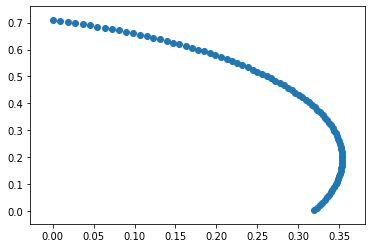

In [7]:
def g(x,y):
    return (x+0.2)**2+(y-0.2)**2-0.3

(x,y)=simple_contour(g)
plt.scatter(x,y)
plt.show()

Réussite pour cet exemple ! Essayons quelque chose de plus corsé en demandant un résultat sur un pavé plus grand... $[-1,1]^2$

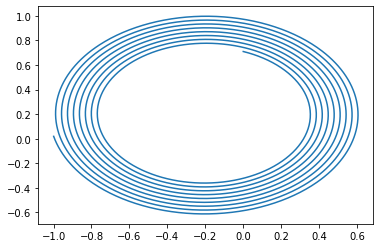

In [8]:
#Modification de simple contour
def simple_contour(f,c=0.0, delta=0.01):
    X=[]
    Y=[]
    x0=0.
    n=0
    def g(y) :
        return f(x0,y)
    y0=find_seed(g,c)
    if y0!=None :
        a=dPhi(f,x0,y0)
        q=delta/(math.sqrt(1+a**2))
        Y.append(y0)
        X.append(x0)
        xi,yi=q+x0,a*q+y0 #Pour i=1, la racine avec - devant est forcément hors du carré
        while -1<=xi<=1 and -1<=yi<=1 and n<5000: #Etre sûr qu'on reste dans le domaine
            X.append(xi)
            Y.append(yi) #On ajoute le point
            a=dPhi(f,xi,yi)
            xi,yi=prochain_point_tan(X,Y,a,delta)
            n+=1
    x=np.array(X)
    y=np.array(Y)
    return (x,y) 

#Test numéro 2
def g(x,y):
    return (x+0.2)**2+(y-0.2)**2-0.3

(x,y)=simple_contour(g)
plt.plot(x,y)
plt.show()

Problème ! La méthode n'est pas assez précise, le point situé à delta sur la tangente n'est plus sur la ligne de niveau, et le calcul de sa tangente nous éloigne encore, et encore... on diverge et on trace une sorte de spirale !
Comment s'y prendre ? Pour affiner la recherche du prochaint point, on garde la méthode de la tangente puis on cherche un point sur la ligne de niveau à x ou y fixé (égal à celui du point retenu) avec une méthode de Newton.

In [9]:
from scipy import misc

def newton(f, x, tolerance=0.00000000001):
    n=0
    while n<40:
        x1 = x - f(x) / misc.derivative(f, x) 
        t = abs(x1 - x)
        if t < tolerance:
            break
        x = x1
        n+=1
    return x

Pour déterminer si l'on fixe x ou y, on doit regarder le coefficient de la tangente :

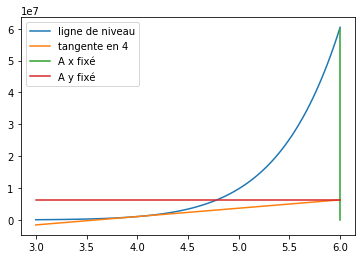

In [10]:
def f(x):
    return x**10


def tan_en_4(x):
    return 4**10+10*(x-4)*4**9

x=np.linspace(3,6,100)    
v1=[6,6]
v2=[0,6*1e7]
h1=[3,6]
h2=[0.629*1e7,0.629*1e7]
plt.plot(x,f(x),label='ligne de niveau')
plt.plot(x,tan_en_4(x),label='tangente en 4')
plt.plot(v1,v2,label='A x fixé')
plt.plot(h1,h2,label='A y fixé')
plt.legend()
plt.show()


Sur cette exemple, on a une ligne de niveau qui "tourne" assez subitement vers 5. Donc, par exemple, quand on a eu comme dernier point 4 et que le prochain donné par la tangente est 6 (NB : on voit bien que la méthode de la tangente n'est pas précise ici) on peut choisir parmi deux options :
- travailler à x fixé, qui correspond à chercher un point très loin (voir infiniment loin, sans trouver de point, alors Newton diverge)
- travailler à y fixé, qui correspond à trouver un point relativement proche de 4, avec convergence de la méthode.

Ceci est directement à lié à la valeur du coefficient directeur : on doit le comparer par rapport à celui de la première bissectrice. Ici a>1, et on choisit de fixer y. On retient donc le test :
- a>1, on fixe y
- sinon, on fixe x

Un dernier cas est possible et aura donné des résultats imparfaits lors de nos expérimentations : celui où a est très grand ou très petit. En effet, alors la tangente est quasi verticale et Newton ne s'applique pas. On doit simplement prendre un point, à x fixé, plus haut ou plus bas de delta selon y.

Dans ce cas, on ajoute une fonctionnalité à notre nouveau simple_contour, qui différenciera quand a est petit de quand a est grand. Pour cela on redéfinit dPhi pour renvoyer un tuple quand a est trop grand, ou trop petit, avec le signe de a :

In [11]:
def dPhi_v2(f,x,y):
    if 0<=grad_f(f,x,y)[1]<1e-3: 
        return (False,1)
    if 0>grad_f(f,x,y)[1]>-1e-3: 
        return (False,-1)
    return(-grad_f(f,x,y)[0]/grad_f(f,x,y)[1])
    

On peut désormais réécrire simple_contour :

In [12]:
def simple_contour_v2(f,c=0.0, delta=0.01):
    X=[]
    Y=[]
    x0=0.
    def g(y) :
        return f(x0,y)-c
    y0=find_seed(g,c)
    if y0!=None :
        a=dPhi(f,x0,y0)
        q=delta/(math.sqrt(1+a**2))
        Y.append(y0)
        X.append(x0)
        xi,yi=q+x0,a*q+y0 #Pour i=1, la racine avec - devant est forcément hors du carré
        n=0
        while -1<=xi<=1 and -1<=yi<=1 and n<5000: #Etre sûr qu'on reste dans le domaine, ici on met -1 pour l'exemple
            X.append(xi)
            Y.append(yi) #On ajoute le point
            a=dPhi_v2(f,xi,yi)
            if type(a)==tuple: 
                yi=yi+a[1]*delta #selon le signe du coefficient a de la tangente
            elif a>1: #On va fixer y
                xt,yt=prochain_point_tan(X,Y,a,delta) #Détermine le prochain point intéressant de la tangente
                def fx(x): #On crée une fonction fx à y fixé
                    return f(x,yt)-c
                xi,yi=newton(fx,xt),yt #On applique Newton à fx
            else:
                xt,yt=prochain_point_tan(X,Y,a,delta)
                def fy(y):
                    return f(xt,y)-c
                xi,yi=xt,newton(fy,yt)
            n+=1
    x=np.array(X)
    y=np.array(Y)
    return (x,y)        
        

L'heure du test est arrivé...

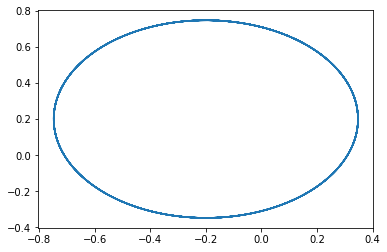

In [13]:
def g(x,y):
    return (x+0.2)**2+(y-0.2)**2-0.3

(x,y)=simple_contour_v2(g)
plt.plot(x,y)
plt.show()

Réussite !

# Partie 3 : contour complexe

## A. Modification de contour simple

Dans cette partie, nous décidons de créer des algorithmes find_seed_v2 et contour_simple_v2 pour faire fonctionner un contour complexe plus léger, bien qu'une autre solution aurait été de créer un contour complexe avec plus de code.

In [14]:
import autograd.numpy as np
from autograd import grad
import math
import matplotlib.pyplot as plt
from scipy import misc

Commençons par redéfinir les fonctions du début (avec la version dPhi_v2)

In [15]:
def grad_f(f,x,y):
    g=grad
    return np.r_[g(f,0)(x,y),g(f,1)(x,y)]

def dPhi_v2(f,x,y):
    if 0<=grad_f(f,x,y)[1]<1e-3: 
        return (False,1)
    if 0>grad_f(f,x,y)[1]>-1e-3: 
        return (False,-1)
    return(-grad_f(f,x,y)[0]/grad_f(f,x,y)[1])
    

def newton(f, x, tolerance=0.00000000001):
    n=0
    while n<40:
        x1 = x - f(x) / misc.derivative(f, x) 
        t = abs(x1 - x)
        if t < tolerance:
            break
        x = x1
        n+=1
    return x


def prochain_point_tan(X,Y,a,delta):
    q=delta/(math.sqrt(1+a**2))
    xt_1,yt_1=q+X[-1],a*q+Y[-1]
    xt_2,yt_2=-q+X[-1],-a*q+Y[-1]
    d1=(xt_1-X[-2])**2+(yt_1-Y[-2])**2
    d2=(xt_2-X[-2])**2+(yt_2-Y[-2])**2
    if d1>d2:
        return(xt_1,yt_1)
    else:
        return(xt_2,yt_2)

Maintenant, attaquons nous à find_seed_v2. L'objectif est que la recherche d'un point sur la ligne de niveau s'effectue sur les 4 arêtes de la portion d'espace que nous avons découpé. On va aussi faire en sorte que la recherche s'arrête dès qu'un point est trouvé (pas besoin de chercher sur les autres arêtes). Pour ce programme, on considère que contour complexe peut transférer le problème d'étude d'une portion quelconque de l'espace d'étude (de bonne taille) à notre précédent ensemble d'étude $[0,1]^2$.

Rappelons que find_seed doit fixer une variable de f (x ou y) et appliquer une dichotomie en fonction de l'autre variable. Le problème est que la précédente version de find_seed effectue la recherche sur l'unique arête où x=0. On va donc utiliser une fonction rotateur, qui prend en entrée f et un entier (de 1 à 4, chacun correspondant à une arête) et qui renvoie f avec une variable fixée sur la bonne arête. Le reste de find_seed est identique. On va aussi utiliser une fonction résultat_seed, qui prend en entrée le résultat de la dichotomie et le numéro de l'arête pour renvoyer le couple (x,y) qui va bien.

In [16]:
def find_seed_v2(f, c=0, eps=2**(-26)):
    k=1
    while k<=4:
        g=rotateur(f,k)
        s=(g(1)-c)*(g(0)-c)
        if s<=0:
            a=0
            b=1
            i=(a+b)/2
            while abs(c-g(i))>eps:
                if c>g(i):
                    a=i
                else:
                    b=i
                i=(a+b)/2
            return résultat_seed(k,i)
        k+=1
    return None,None

Maintenant, définissons rotateur et résultat_seed avec le formalisme suivant (voir résultat du code suivant) :

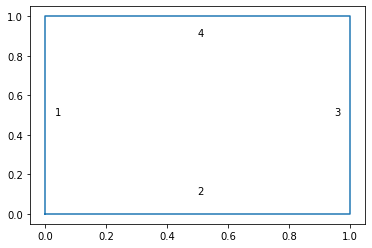

In [17]:
x=[0,0,1,1,0]
y=[0,1,1,0,0]
plt.plot(x,y)
plt.text(0.03,0.5,'1')
plt.text(0.95,0.5,'3')
plt.text(0.5,0.1,'2')
plt.text(0.5,0.9,'4')
plt.show()

Ainsi on code :

In [18]:
def rotateur(f,k):
    if k==1:
         return lambda y:f(0,y)
    if k==3:
         return lambda y:f(1,y)
    if k==2:
         return lambda x:f(x,0)
    if k==4:
         return lambda x:f(x,1)

def résultat_seed(k,i):
    if k==1:
         return 0,i
    if k==3:
         return 1,i
    if k==2:
         return i,0
    if k==4:
         return i,1

On peut maintenant réécrire simple_contour. Grâce à find_seed_v2, on change assez peu le code de simple_contour, à une exception près ; maintenant que l'on effectue le test sur toutes les arêtes, il n'est plus possible de prendre x1,y1 aussi facilement que précedemment. En effet avant on était sûr de connaître le point dans le pavé, parmi ceux possibles sur la tangente. Maintenant, on doit ajouter un test sur ce point aussi, grâce à un algorithme semblable à celui défini pour prochain_point_tan, que l'on nomme ici premier_point et que voici :

In [19]:
def Premier_point(x0,y0,a,delta):
    q=delta/(math.sqrt(1+a**2))
    x1_1,y1_1=q+x0,a*q+y0
    x1_2,y1_2=-q+x0,-a*q+y0
    if 0<=x1_1<=1 and 0<=y1_1<=1:
        return(x1_1,y1_1)
    else:
        return(x1_2,y1_2)

Grâce à cette fonction on peut définir simple_contour_v3 :

In [20]:
def simple_contour_v3(f,c=0.0, delta=0.01):
    X=[]
    Y=[]
    x0,y0=find_seed_v2(f,c)
    if x0 is not None and y0 is not None :
        x0,y0=float(x0),float(y0)
        a=dPhi(f,x0,y0)
        Y.append(y0)
        X.append(x0)
        xi,yi=Premier_point(x0,y0,a,delta) #Comme on est sur une des 4 arêtes, on doit tester
        n=0
        while 0<=xi<=1 and 0<=yi<=1 and n<500: 
            X.append(xi)
            Y.append(yi) #On ajoute le point
            a=dPhi(f,xi,yi)
            if type(a)==tuple:
                yi=yi+a[1]*delta
            elif a>1:
                xt,yt=prochain_point_tan(X,Y,a,delta) 
                def fx(x):
                    return f(x,yt)-c
                xi,yi=newton(fx,xt),yt
            else:
                xt,yt=prochain_point_tan(X,Y,a,delta)
                def fy(y):
                    return f(xt,y)-c
                xi,yi=xt,newton(fy,yt)
            n+=1
    return X,Y 

Maintenant que simple_contour_v3 est défini, on peut le tester (voir résultat du code suivant) :

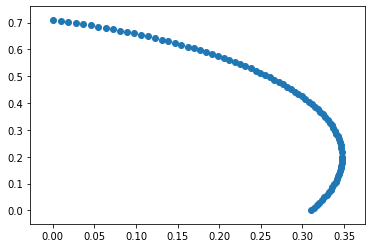

In [21]:
def g(x,y):
    return (x+0.2)**2+(y-0.2)**2-0.3

(x,y)=simple_contour_v3(g)
plt.scatter(x,y)
plt.show()
#Succès !

On a donc un simple_contour_v3 qui fonctionne, on peut définir contour.

## B. Définition de contour

Dans notre fonction contour, on fait appel à simple_contour_v2 sur chaque cellule. Simple_contour_v2 est déjà très complet, on a donc seulement à diviser notre espace en cellule, et à effectuer une translation pour que chaque cellule soit équivalente à une étude sur $[0,1]^2$ (tout en gardant le fonctionnement de f donc). Il vient assez naturellement :

In [22]:
def contour(f, c=0.0, xc=[0.0,1.0], yc=[0.0,1.0], delta=0.01):
    xs=[]
    ys=[]
    lini=xc[1]-xc[0] #taille de chaque cellule
    for xci,yci in zip(xc,yc):
        def fu(x,y): #nouvelle fonction f centrée sur la cellule
            return (f((x-xci)/lini,(y-yci)/lini))
        X=[x*lini+xci for x in simple_contour_v3(fu,c,delta)[0]]
        Y=[y*lini+yci for y in simple_contour_v3(fu,c,delta)[1]]
        xs.append(X)
        ys.append(Y)
    return xs,ys

Reste à tester contour avec une première fonction très simple (gardons celle de contour_simple) :

In [23]:
def g(x,y):
    return (x+0.2)**2+(y-0.2)**2-0.3

xs, ys = contour(g, 0, np.linspace(-1,1,10), np.linspace(-1,1,10))
for x, y in zip(xs,ys):
    plt.scatter(x,y)
plt.show()
#Interrompre le noyau après quelques dizaines de secondes

KeyboardInterrupt: 

Problème, aucun résultat, aucun graphique en sortie. Le programme continue de tourner en permanence, donc. Essayons d'identifier la source du problème, qui doit être en rapport avec contour, en ajoutant un print(X) avant de faire xs.append(X) :

In [24]:
def contour(f, c=0.0, xc=[0.0,1.0], yc=[0.0,1.0], delta=0.01):
    xs=[]
    ys=[]
    lini=xc[1]-xc[0] #taille de chaque cellule
    for xci,yci in zip(xc,yc):
        def fu(x,y): #nouvelle fonction f centrée sur la cellule
            return (f((x-xci)/lini,(y-yci)/lini))
        X=[x*lini+xci for x in simple_contour_v3(fu,c,delta)[0]] #Ramener les lignes de niveau sur la bonne cellule
        Y=[y*lini+yci for y in simple_contour_v3(fu,c,delta)[1]]
        print(X)
        xs.append(X)
        ys.append(Y)
    return xs,ys

def g(x,y):
    return (x+0.2)**2+(y-0.2)**2-0.3

xs, ys = contour(g, 0, np.linspace(-1,1,10), np.linspace(-1,1,10))
for x, y in zip(xs,ys):
    plt.scatter(x,y)
plt.show()

[]
[]
[]
[]
[]
[]
[]
[]
[]


KeyboardInterrupt: 

On voit donc que contour marche d'abord sur quelques cellules vides, et semble planter en rencontrant une cellule dans laquelle on doit trouver une ligne de niveau. L'une de nos hypothèses porte sur le fait que simple_contour_v3 présente un problème d'exécution au moment où il doit renvoyer autre chose que None. Mais, en parallèle, cette fonction marche parfaitement. Malgré plusieurs tests et réécritures non fructueux, nous sommes donc à court d'idées.